# Python ile Coğrafi Dosyayı Maskeleme ve Sınıflandırma

## Sınıflandırma fonksiyonu

### Geometrik aralıklı sınıflandırma (Geometric interval classifiaction)

Geomerik serinin genel formu aşağıdaki şekilde tanımlanır.
<br>
$$a, ar, ar^{2}, ar^{3}, ... , ar^{n-1}$$
<br>
Burada bir verş setini geometrik seri açılımından faydalanarak 0 ile 100 değerleri arasında $n$ adet sınıfta tanımlayacağız. 

**Geometrik aralıklı sınıflandırma işlemi**
<br>
<br>
Kullanıcıdan yalnızca sınıf sayısı ($n$) istenir. Diğer değerler hesaplanır. 
<br>
<br>
Sabit değerin ($a$) bulunması için iteratif bir çözüm uydurulmuştur. Verilerin dağılımı içerisinde 1'in sınıf sayısına bölünmesiyle elde edilen yüzdelik dilimin üstel ifade ($r$) ile çarpılması iteratif olarak çözülür. Belirlenen hata mertebesinden mertebesinden küçük olana kadar bu çözüme devam edilir.
<br>
Bilgi: https://www-users.york.ac.uk/~mb55/intro/quantile.htm
<br>
$$\frac{1}{n} \rightarrow Q$$
<br>
$$a_1={r_1}{Q_1}\;\;\;...\;\;\;a_m={r_m}{Q_m} \;\; (Error<10^{-5})$$
<br>
$$Error = \frac{|a_m - a_{m-1}|}{a_m}$$
<br>
$m$: İterasyon sayısı
<br>
<br>
Üstel ifadeyi ($r$) bulmak için veri setinin maksimum değeri en büyük sınıf değeri olarak belirlenir.
<br>
$$ar^{n-1}=max(Data)$$
<br>
Bu ifadeden $r$ değeri çekilir.
<br>
$$r=\sqrt[n-1]{\frac{max(Data)}{a}}$$

In [1]:
# Geometrik aralıklı sınıflandırma için gerekli kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from copy import copy

%matplotlib inline
sns.set()


In [2]:
"""
Geometrik aralıklı sınıflandırma fonksiyonu

Değişkenler:
 df_: dataframe
 classNumber: Kaç adet sınıf kullanılacağı (n)
 constant: Serideki sabit değer (a)
 rValue: Üstel ifade (r)
"""
    
def gi_classify(df_, classNumber):  
    constant = []
    
    try:
        rValue = 1
        error = 1e-5
        
        # Not: İteratif olarak constant hesaplama yöntemi uydurdum.
        for i in range(0, 999):
            constant.append(rValue * df_.Intensity.quantile(1 / classNumber))
            rValue = (df_.Intensity.max() / constant[i]) ** (1 / (classNumber - 1))   
        
            if (i != 0 and abs(constant[i] - constant[i - 1]) / constant[i] <= error):
                break
                
        """
        quantile işlevi JavaScript'te mevcut değilse onun fonksiyonunu ayrı 
        yazabiirim ya da constant değerini de classify fonksiyonuna input olarak 
        verebiliriz.
        """
        
        # Grafik için
        num = i + 1
        x = np.linspace(1, i + 1, num=num, endpoint=True)
        y = constant
        
        num = 5 * (i + 1)
        xnew = np.linspace(1, i + 1, num=num, endpoint=True)
        f = interp1d(x, y, kind="cubic")
        
        plt.plot(x, y, "o", xnew, f(xnew), "-", color="navy")
        
        plt.xlabel("Iteration")
        plt.ylabel("Constant value")
        plt.show()
        
    except RuntimeWarning:
        # Değerler 0'a yakınsarsa constant'a sabit bir sayı atanır.
        constant[0] = 10000
        rValue = (df_.Intensity.max() / constant[0]) ** (1 / (classNumber - 1))   
    
    endC = len(constant) - 1
    
    print("classNumber: {}".format(classNumber))
    print("constant: {}".format(constant[endC]))
    print("rValue: {}".format(rValue))
    
    dfCopy = copy(df_)
    dfCopy.Intensity = 100 / classNumber
    
    classes = []
    percentages = []
    
    # Sınıf değerleri ve yüzde aralıkları oluşturulur.
    for i in range(0, classNumber):
        classes.append(constant[endC] * (rValue ** i))
        percentages.append((i + 1) * (100 / classNumber))
    
    print("classes: {}".format(classes))
    print("percentages: {}".format(percentages))
    
    # Eşdeğer yüzdesel değerler dfCopy içerisine aktarılır.
    for i in range(classNumber - 1, -1, -1):    
        dfCopy.Intensity = np.where(df_.Intensity <= classes[i], percentages[i], dfCopy.Intensity)
        
    return dfCopy.Intensity


## Maskeleme fonksiyonu

Maskeleme işlemi yapılırken shape (*.shp*) dosyalarından faydalanılabilir. Bunun için dosyaların içerisindeki koordinat bilgilerini *geometry object*'lere dönüştürülmesi gereklidir. *GeoPandas* modülü kullanılarak maskleme işlemi yapılır.

In [3]:
# Maskeleme için gerekli ekstra kütüphaneler
import geopandas as gpd
from shapely.geometry import Point


In [4]:
"""
Maskeleme fonksiyonu

Değişkenler:
 df_: dataframe
 countryName: Ülke kodu (örn:"AUT")
"""

def mask (df_, countryName):
    # Shape dosyasından geo dataframe oluştur
    shapeFile = "ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp" 
    gdf_country = gpd.read_file(shapeFile)[["ADM0_A3", "geometry"]] # Ülke kodu ve sınırları
    
    # İstenilen ülkeyi seç
    selectedCountry = gdf_country.loc[gdf_country.ADM0_A3 == countryName]
    
    # Dosya işlemleri
    selectedCountry.index = selectedCountry.ADM0_A3
    selectedCountry = selectedCountry.drop(columns=["ADM0_A3"])
    
    def visualize_ (data, title):
        data.plot(color="navy")
        plt.title(title)
        plt.xlabel("Lon")
        plt.ylabel("Lat")
        plt.show()
    
    # Seçili ülkeyi göster
    visualize_(selectedCountry, "Country: " + countryName)
    
    # Dataframe'deki koordinatları geometry'ye dönüştür 
    geometry = [Point(xy) for xy in zip(df_['Lon'], df_['Lat'])]
    
    # df2gdf
    gdf_points = gpd.GeoDataFrame(df_, crs='WGS84', geometry=geometry)
    
    # Dosya işlemleri
    gdf_points = gdf_points.drop(columns=["Lat", "Lon"])
        
    # Noktaları göster
    visualize_(gdf_points, "Points")
    
    # Kesişimi al
    intersectionPoints = gpd.overlay(gdf_points, selectedCountry, how="intersection")

    # Veriyi yazdır
    data = {'Lat': intersectionPoints.geometry.y
            , 'Lon': intersectionPoints.geometry.x
            , 'Intensity': intersectionPoints.Intensity}
    
    newdf = pd.DataFrame(data)
    
    return newdf
    

## Veri işleme

In [5]:
# Veri setini al
fileName = "lightning_heat_map_austria.csv"
df = pd.read_csv(fileName)


In [6]:
# Dataframe
df


,Lat,Lon,Intensity
0,45.686083,8.550842,0.000000
1,45.686083,8.730505,0.134601
2,45.686083,8.910168,148.267476
3,45.686083,9.089832,600.396757
4,45.686083,9.269495,844.344459
...,...,...,...
1885,49.803159,17.354332,77.935395
1886,49.803159,17.533995,29.170868
1887,49.803159,17.713658,0.249981
1888,49.803159,17.893321,0.000000


In [7]:
# Dataframe'in özellikleri
df.describe()


,Lat,Lon,Intensity
count,1890.000000,1890.000000,1890.000000
mean,47.771141,13.311913,72362.795062
std,1.223322,2.800931,47737.786765
min,45.686083,8.550842,0.000000
25%,46.684345,10.886462,37901.506197
50%,47.785610,13.311913,72688.009392
75%,48.863891,15.737365,104787.298661
max,49.803159,18.072984,214337.026872


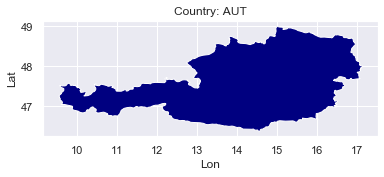

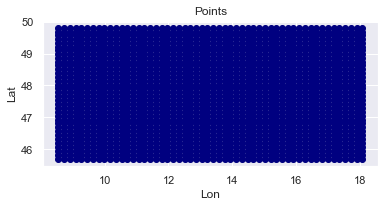

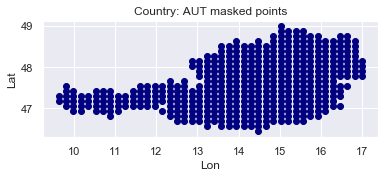

,Lat,Lon,Intensity
0,46.436490,14.479723,101589.675921
1,46.560560,13.222082,112114.773852
2,46.560560,13.581408,107706.927325
3,46.560560,13.761071,108601.004872
4,46.560560,13.940734,107045.309012
...,...,...,...
451,48.863891,15.018712,71719.226013
452,48.863891,15.198375,62374.438183
453,48.863891,15.378039,55457.205639
454,48.863891,15.557702,54346.458408


In [8]:
# Maskele
countryCode = "AUT"
masked_df = copy(df)
masked_df = mask(masked_df, countryCode)

# Maskelenmiş noktaları göster
geometry = [Point(xy) for xy in zip(masked_df['Lon'], masked_df['Lat'])]
masked_gdf = gpd.GeoDataFrame(copy(masked_df), crs='WGS84', geometry=geometry)
masked_gdf = masked_gdf.drop(columns=["Lat", "Lon"])
masked_gdf.plot(color="navy")
title = "Country: " + countryCode + " masked points"  
plt.title(title)
plt.xlabel("Lon")
plt.ylabel("Lat")
plt.show()

masked_df


### Tüm dosya için sınıflandırma

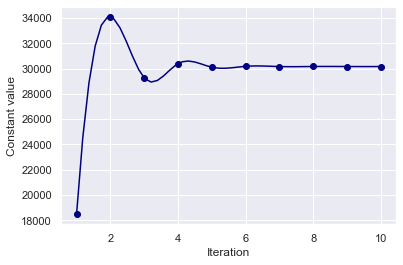

classNumber: 5
constant: 30157.44476349069
rValue: 1.6327724553848701
classes: [30157.44476349069, 49240.245134618286, 80398.11595220362, 131271.82919159697, 214337.02687202708]
percentages: [20.0, 40.0, 60.0, 80.0, 100.0]


In [9]:
# Sınıf sayısı
classNumber = 5

# Tüm dosyayı sınıflandır
classified_df = copy(df)
classified_df.Intensity = gi_classify(classified_df, classNumber)


In [10]:
# Sınıflandırılmış dataframe
classified_df


,Lat,Lon,Intensity
0,45.686083,8.550842,20.0
1,45.686083,8.730505,20.0
2,45.686083,8.910168,20.0
3,45.686083,9.089832,20.0
4,45.686083,9.269495,20.0
...,...,...,...
1885,49.803159,17.354332,20.0
1886,49.803159,17.533995,20.0
1887,49.803159,17.713658,20.0
1888,49.803159,17.893321,20.0


In [11]:
# Dosyaya yazdır
classified_df.to_csv("map_classified_" + fileName, index=None)


### Maskelenmiş dosya için sınıflandırma

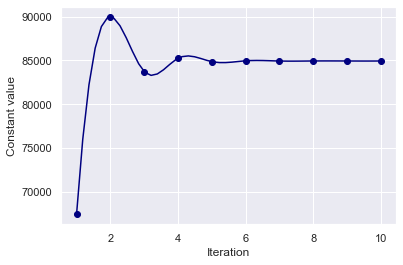

classNumber: 5
constant: 84943.95960277165
rValue: 1.2603500274651795
classes: [84943.95960277165, 107059.12181835435, 134931.9671241609, 170061.50847086692, 214337.02687202697]
percentages: [20.0, 40.0, 60.0, 80.0, 100.0]


In [12]:
# Sınıf sayısı
classNumber = 5

# Tüm dosyayı sınıflandır
classified_masked_df = copy(masked_df)
classified_masked_df.Intensity = gi_classify(classified_masked_df, classNumber)


In [13]:
# Sınıflandırılmış dataframe
classified_masked_df


,Lat,Lon,Intensity
0,46.436490,14.479723,40.0
1,46.560560,13.222082,60.0
2,46.560560,13.581408,60.0
3,46.560560,13.761071,60.0
4,46.560560,13.940734,40.0
...,...,...,...
451,48.863891,15.018712,20.0
452,48.863891,15.198375,20.0
453,48.863891,15.378039,20.0
454,48.863891,15.557702,20.0


In [14]:
# Dosyaya yazdır
classified_masked_df.to_csv("map_classified_" + countryCode + "_masked_" + fileName, index=None)


**Kullanışlı linkler:**
<br>
<br>
https://en.wikipedia.org/wiki/Geometric_progression
<br>
http://wiki.gis.com/wiki/index.php/Geometric_Interval_Classification
<br>
https://pro.arcgis.com/en/pro-app/help/mapping/layer-properties/data-classification-methods.htm